# Binary Classification of 747 vs A380
The goal is to classify a picture between two classes : an Boeing 747 or an Airbus A380.
*Spoiler :* This source code is 3 times better than Google AutoML on the same dataset !

Note : this Notebook was writen with old version  of fastai librairy and updated fot the new version.
For now, the old version (https://github.com/trancept/deep_learning_tests/blob/master/012-Binary_Classification_747_vs_A380-essential.ipynb) perform much better (98% accuracy vs 95%), I've to figure out why.

You may notice a strange line :

 !rm -r {PATH}tmp

It's there to remove temporary files to avoid messing out between different training.

## Dataset
It's an homemade dataset from Google Image.
There is a nice script to get images from Google : https://github.com/boxabirds/fastai-helpers/blob/master/training-data-generator.py, it's based on https://github.com/hardikvasa/google-images-download wich use ChromeDriver to automate the process.

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
PATH = "../../datasets/boeing_vs_airbus/"
!rm -r {PATH}tmp
## Getting dataset
#!mkdir {PATH}
#!pip install google_images_download
#!ls ../../datasets/
#!cd {PATH} && mkdir -p train/747 train/A380 test/747 test/A380  valid/747 valid/A380
#!cd {PATH}/747 && googleimagesdownload --keywords "Boing 747" --limit 1000 --chromedriver /usr/local/bin/chromedriver
#!cd {PATH}/A380 && googleimagesdownload --keywords "Airbus A380" --limit 1000 --chromedriver /usr/local/bin/chromedriver
## Getting models weights
#!cd ./fastai && wget http://files.fast.ai/models/weights.tgz && tar -xvzf weights.tgz
#!ls {PATH}

rm: cannot remove '../../datasets/boeing_vs_airbus/tmp': No such file or directory


In [3]:
print("Setting CUDA devices...")
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="6"

print("Loading Fast.AI modules...")
from fastai import *
from fastai.vision import *

sz=224
arch=models.resnet50
bs=132

Setting CUDA devices...
Loading Fast.AI modules...


In [4]:
print("CuDNN optimization is ", torch.backends.cudnn.enabled)

CuDNN optimization is  True


# Training from sratch
We begin with an empty Resnet50 model.

### Prepare data and model

First we compute the mean and standard deviation of all images to center them.

It will help calculus to have a mean of 0 and a standard deviation of 1.

_23 october note :_ In the new version of fastai librairy you could do it in one line :
data.normalize(imagenet_stats)

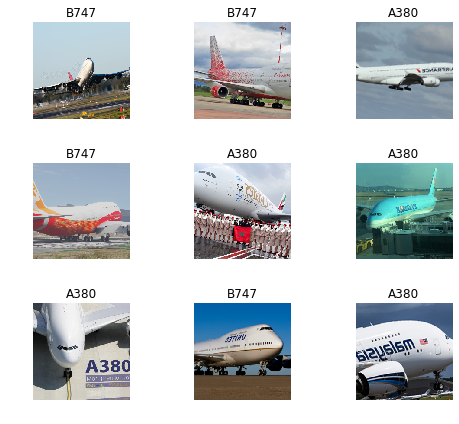

In [5]:
data = ImageDataBunch.from_folder(PATH, ds_tfms=get_transforms(), size=224)
data.normalize(imagenet_stats)
data.show_batch(rows=3, figsize=(7,6))
learn = ConvLearner(data, arch, metrics=error_rate) #accuracy

In [6]:
data.classes

['A380', 'B747']

How much input data do we have ?

(array([617.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 587.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

(array([154.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 154.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

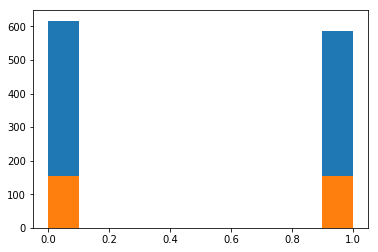

In [7]:
plt.hist(data.train_ds.ds.y)
plt.hist(data.valid_ds.ds.y)

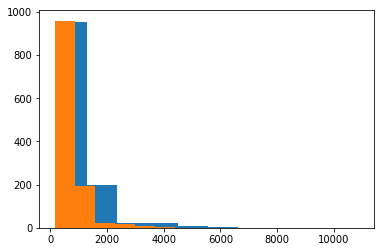

In [10]:
from PIL import Image
size_d = {k: Image.open(k).size for k in data.train_ds.ds.x}
row_sz, col_sz = list(zip(*size_d.values()))
row_sz = np.array(row_sz)
col_sz = np.array(col_sz)
plt.hist(row_sz);
plt.hist(col_sz);

Zoom on size below 1 000 pixels

(array([ 18.,  45.,  45.,  67., 112., 155.,  75.,  94.,  32.,  53.]),
 array([220. , 297.2, 374.4, 451.6, 528.8, 606. , 683.2, 760.4, 837.6,
        914.8, 992. ]),
 <a list of 10 Patch objects>)

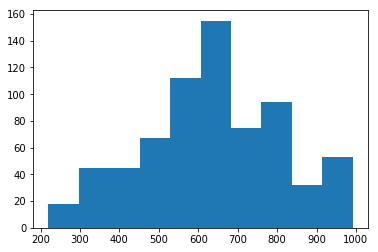

In [11]:
plt.hist(row_sz[row_sz < 1_000])

We have few data, but sizes are good.

### Guess learning rate

In [12]:
lrf=learn.lr_find(1e-6, end_lr=1)

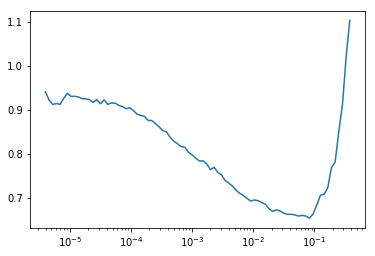

In [13]:
learn.recorder.plot()

Unfortunatly the learning rate finder do not work well with small dataset.

_23 october note :_ In the new version of fastai librairy it seems to work !

In [14]:
lr=1e-4
image_size=128
batch_size=64
epoch=30
data = ImageDataBunch.from_folder(PATH, ds_tfms=get_transforms(do_flip=False, flip_vert=False, max_rotate=0, max_zoom=0),
                                  size=224, num_workers=num_cpus()-2)
data.normalize(imagenet_stats)

In [15]:
learn = ConvLearner(data=data, arch=arch, ps=0.5, pretrained=False, metrics=accuracy)
learn.fit(epochs=epoch, lr=lr)

Total time: 10:32
epoch  train loss  valid loss  accuracy
1      0.926629    0.702520    0.500000  (00:25)
2      0.900509    0.707717    0.493506  (00:20)
3      0.873751    0.763600    0.487013  (00:22)
4      0.871082    0.724759    0.548701  (00:21)
5      0.863634    0.733456    0.532468  (00:21)
6      0.851799    0.690164    0.584416  (00:20)
7      0.839885    0.726047    0.538961  (00:21)
8      0.825562    0.750831    0.538961  (00:21)
9      0.827199    0.702972    0.542208  (00:20)
10     0.810071    0.712915    0.564935  (00:20)
11     0.816677    0.768334    0.548701  (00:21)
12     0.807358    0.752913    0.561688  (00:21)
13     0.804188    0.717087    0.538961  (00:20)
14     0.797225    0.719883    0.545455  (00:20)
15     0.789663    0.724382    0.555195  (00:19)
16     0.789521    0.746010    0.584416  (00:19)
17     0.782147    0.734992    0.529221  (00:21)
18     0.777506    0.725819    0.519481  (00:20)
19     0.772770    0.711116    0.538961  (00:20)
20     0.77

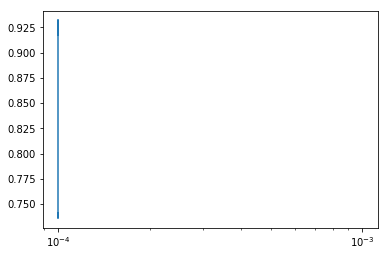

In [16]:
learn.recorder.plot()

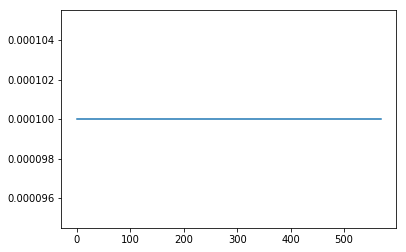

In [17]:
learn.recorder.plot_lr()

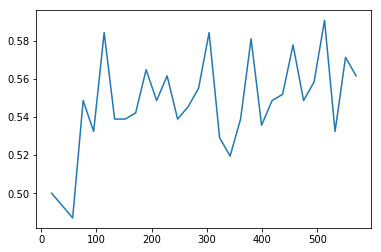

In [18]:
learn.recorder.plot_metrics()

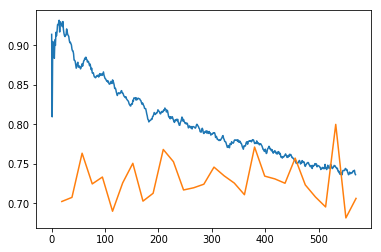

In [19]:
learn.recorder.plot_losses()

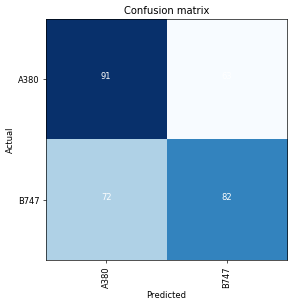

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

The model had learn quite nothing. But it is not surprising with so small dataset.

## Fine tuning

We will now use a pre-trained on ImageNet of resnet.

In [22]:
!rm -r {PATH}tmp

image_size=128
batch_size=64
learning_rate = 1e-3
lr=np.array([learning_rate/5,learning_rate/3,learning_rate])
epoch=30

data = ImageDataBunch.from_folder(PATH, ds_tfms=get_transforms(do_flip=False, flip_vert=False, max_rotate=0, max_zoom=0),
                                  size=224, num_workers=num_cpus()-2)
data.normalize(imagenet_stats)
learn = ConvLearner(data=data, arch=arch, ps=0.5, pretrained=True, metrics=accuracy)
learn.unfreeze()
learn.fit(epochs=epoch, lr=lr)

rm: cannot remove '../../datasets/boeing_vs_airbus/tmp': No such file or directory


Total time: 10:37
epoch  train loss  valid loss  accuracy
1      0.713629    0.606377    0.762987  (00:21)
2      0.480722    0.506248    0.834416  (00:20)
3      0.341862    0.375491    0.870130  (00:20)
4      0.243201    0.274949    0.889610  (00:19)
5      0.177624    0.300904    0.886364  (00:22)
6      0.133634    0.476034    0.814935  (00:20)
7      0.112506    0.300428    0.905844  (00:21)
8      0.101304    0.994006    0.769481  (00:20)
9      0.102776    0.277661    0.902597  (00:23)
10     0.097327    0.364441    0.870130  (00:22)
11     0.085971    0.317114    0.896104  (00:19)
12     0.076231    0.445170    0.866883  (00:20)
13     0.073645    0.374325    0.873377  (00:21)
14     0.071797    0.292175    0.876623  (00:21)
15     0.067318    0.284211    0.905844  (00:21)
16     0.055326    0.314408    0.909091  (00:20)
17     0.048037    0.292454    0.918831  (00:22)
18     0.044955    0.341674    0.896104  (00:21)
19     0.062790    0.490421    0.860390  (00:21)
20     0.06

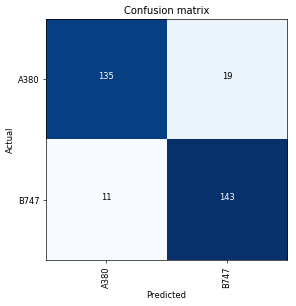

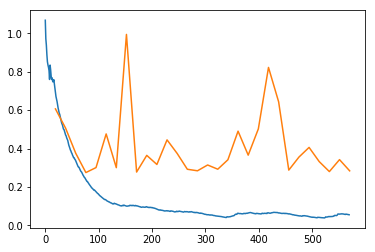

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)
learn.recorder.plot_losses()

Fine tunning realy improve the accuracy, it is the first thing to do with any project.

## Data augmentation
Apply random operations on pictures to help the model to generalize.
Data augmentation options : https://becominghuman.ai/data-augmentation-using-fastai-aefa88ca03f1

In [24]:
tfms = get_transforms(do_flip=True, flip_vert=False, max_rotate=10, max_zoom=1.1)

In [25]:
!rm -r {PATH}tmp
image_size=128
batch_size=64
learning_rate = 1e-3
lr = np.array([learning_rate/5,learning_rate/3,learning_rate])
epoch=30

data = ImageDataBunch.from_folder(PATH, ds_tfms=tfms, size=224, num_workers=num_cpus()-2)
data.normalize(imagenet_stats)
learn = ConvLearner(data=data, arch=arch, ps=0.5, pretrained=True, metrics=accuracy)
learn.unfreeze()
learn.fit(epochs=epoch, lr=lr)

rm: cannot remove '../../datasets/boeing_vs_airbus/tmp': No such file or directory


Total time: 10:41
epoch  train loss  valid loss  accuracy
1      0.603727    1.022580    0.714286  (00:22)
2      0.417499    0.298983    0.866883  (00:21)
3      0.313935    0.285598    0.889610  (00:20)
4      0.227330    0.476590    0.860390  (00:21)
5      0.183532    0.190758    0.915584  (00:22)
6      0.159327    0.245326    0.902597  (00:22)
7      0.139186    0.281975    0.879870  (00:22)
8      0.123462    0.203924    0.899351  (00:21)
9      0.115380    0.411119    0.860390  (00:21)
10     0.103433    0.244749    0.905844  (00:21)
11     0.092395    0.339266    0.896104  (00:21)
12     0.083247    0.277802    0.899351  (00:20)
13     0.081120    0.251850    0.909091  (00:22)
14     0.093328    0.272428    0.918831  (00:21)
15     0.083954    0.206410    0.918831  (00:20)
16     0.076581    0.252844    0.896104  (00:21)
17     0.075172    0.732277    0.837662  (00:19)
18     0.082709    0.364210    0.876623  (00:20)
19     0.081907    0.288723    0.899351  (00:21)
20     0.07

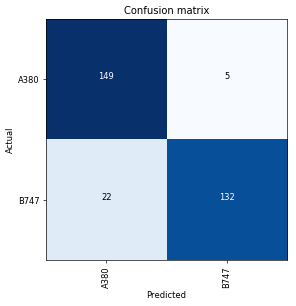

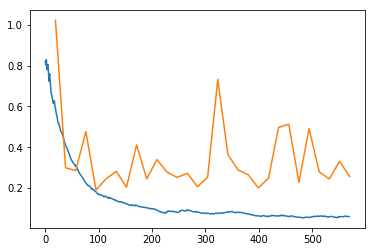

In [26]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)
learn.recorder.plot_losses()

Using data augmentation improve the accuracy by XX points.

## Multiple images sizes

Begining with smaller size of images sometimes improve the training accuracy.

In [27]:
!rm -r {PATH}tmp
learning_rate = 1e-3
learning_rate = np.array([learning_rate/5,learning_rate/3,learning_rate])
dropout = 0.5 #[0.25,0.5]
image_size = 128
batch_size = 64


data = ImageDataBunch.from_folder(PATH, ds_tfms=tfms, size=224) # ds_tfms=get_transforms()
data.normalize(imagenet_stats)
learn = ConvLearner(data=data, arch=arch, ps=0.5, pretrained=True, metrics=accuracy)
learn.unfreeze()

training_loop = [
    [123, 64, 10],
    [150, 128, 10],
    [123, 224, 10],
]
for bs, sz, epoch in training_loop:
    data.batch_size = bs
    learn.fit(epochs=epoch, lr=lr)

rm: cannot remove '../../datasets/boeing_vs_airbus/tmp': No such file or directory


Total time: 03:16
epoch  train loss  valid loss  accuracy
1      0.735389    1.017168    0.711039  (00:18)
2      0.518743    0.483612    0.840909  (00:20)
3      0.370354    0.317810    0.879870  (00:20)
4      0.280647    0.278498    0.883117  (00:20)
5      0.233340    0.355741    0.883117  (00:19)
6      0.185225    0.329436    0.873377  (00:20)
7      0.152799    0.312622    0.876623  (00:21)
8      0.134220    0.353566    0.863636  (00:18)
9      0.115057    0.290390    0.902597  (00:18)
10     0.109431    0.363587    0.879870  (00:18)



Total time: 03:12
epoch  train loss  valid loss  accuracy
1      0.183569    0.474938    0.860390  (00:19)
2      0.152921    0.490029    0.876623  (00:19)
3      0.136134    0.469202    0.860390  (00:18)
4      0.125352    0.272342    0.912338  (00:20)
5      0.105549    0.281353    0.912338  (00:18)
6      0.102317    0.363734    0.876623  (00:19)
7      0.094329    0.388463    0.883117  (00:18)
8      0.087511    0.260521    0.902597  (00:19)
9      0.081472    0.304720    0.912338  (00:19)
10     0.079071    0.248884    0.909091  (00:19)



Total time: 03:14
epoch  train loss  valid loss  accuracy
1      0.094119    0.347182    0.896104  (00:19)
2      0.091744    0.343795    0.879870  (00:21)
3      0.087367    0.249727    0.909091  (00:18)
4      0.079360    0.281135    0.879870  (00:21)
5      0.078299    0.312142    0.886364  (00:19)
6      0.075536    0.255699    0.905844  (00:19)
7      0.073561    0.286245    0.902597  (00:18)
8      0.067590    0.300292    0.896104  (00:18)
9      0.060768    0.241069    0.918831  (00:18)
10     0.055212    0.283508    0.902597  (00:18)



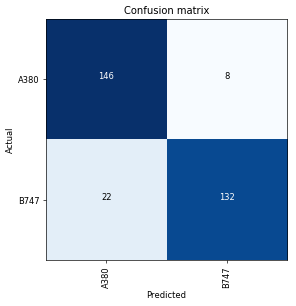

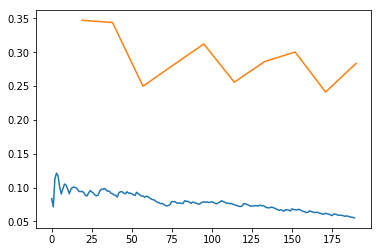

In [28]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)
learn.recorder.plot_losses()

Well, using multiple size did not realy help but it is something to try.

## SGDR - Learning rate anealing

We now use special training procedure wich made learning rate change while learning.

In [29]:
!rm -r {PATH}tmp


learning_rate = 1e-3
lr=np.array([learning_rate/5,learning_rate/3,learning_rate])
dropout = 0.5
#[0.25,0.5] 


data = ImageDataBunch.from_folder(PATH, ds_tfms=tfms, size=224) # ds_tfms=get_transforms()
data.normalize(imagenet_stats)
learn = ConvLearner(data=data, arch=arch, ps=0.5, pretrained=True, metrics=accuracy)
learn.unfreeze()

training_loop = [
    [123, 64, 10],
    [150, 128, 10],
    [123, 224, 10],
]
for bs, sz, epoch in training_loop:
    data.batch_size = bs
    learn.fit_one_cycle(cyc_len=epoch, max_lr=lr)

rm: cannot remove '../../datasets/boeing_vs_airbus/tmp': No such file or directory


Total time: 03:19
epoch  train loss  valid loss  accuracy
1      0.736711    0.530121    0.753247  (00:20)
2      0.503553    0.372192    0.847403  (00:19)
3      0.370679    0.367715    0.889610  (00:18)
4      0.308661    0.378083    0.902597  (00:19)
5      0.248630    0.298328    0.886364  (00:19)
6      0.197656    0.239304    0.892857  (00:19)
7      0.157734    0.268465    0.912338  (00:20)
8      0.120327    0.279209    0.896104  (00:21)
9      0.090911    0.217738    0.912338  (00:19)
10     0.071873    0.226578    0.909091  (00:20)



Total time: 03:16
epoch  train loss  valid loss  accuracy
1      0.031864    0.221754    0.928571  (00:19)
2      0.061389    0.426956    0.863636  (00:18)
3      0.117504    0.395403    0.883117  (00:20)
4      0.136949    0.433244    0.837662  (00:18)
5      0.135749    0.257412    0.899351  (00:20)
6      0.118014    0.240111    0.889610  (00:19)
7      0.094534    0.183686    0.925325  (00:18)
8      0.076270    0.190826    0.922078  (00:20)
9      0.059029    0.173913    0.922078  (00:18)
10     0.047964    0.170995    0.925325  (00:21)



Total time: 03:15
epoch  train loss  valid loss  accuracy
1      0.019643    0.214537    0.938312  (00:19)
2      0.035932    0.548786    0.863636  (00:19)
3      0.059576    0.498404    0.876623  (00:18)
4      0.087818    0.657767    0.827922  (00:19)
5      0.102599    0.615220    0.801948  (00:19)
6      0.091636    0.211623    0.918831  (00:20)
7      0.077200    0.227480    0.928571  (00:18)
8      0.064828    0.265711    0.905844  (00:19)
9      0.049139    0.232877    0.928571  (00:19)
10     0.047284    0.231805    0.935065  (00:19)



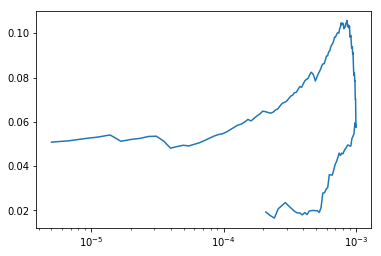

In [30]:
learn.recorder.plot()

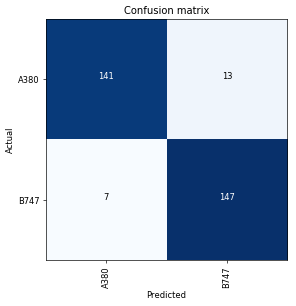

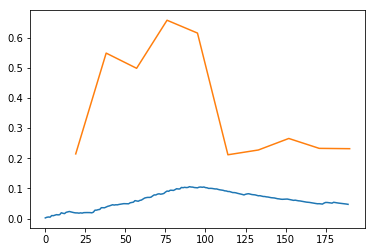

In [31]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)
learn.recorder.plot_losses()

OK, that give us another XXX points improvement !

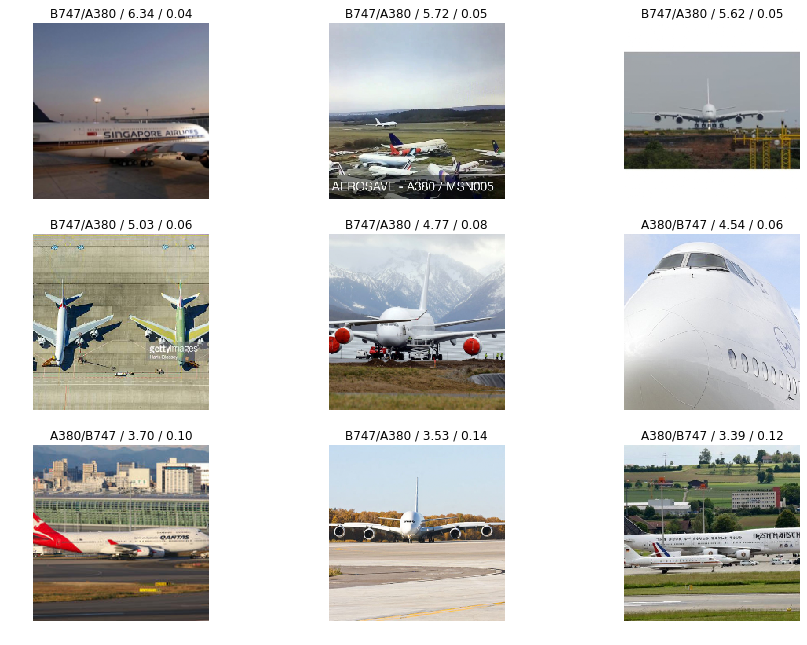

In [32]:
interp.plot_top_losses(9, figsize=(15,11))

In [33]:
learn.save('lesson01-final_model')

In [34]:
#loadmodel=False
loadmodel=True
if loadmodel==True:
    data = ImageDataBunch.from_folder(PATH, ds_tfms=get_transforms(), size=224)
    learn = ConvLearner(data=data, arch=arch, ps=0.5, pretrained=True, metrics=accuracy)
    #learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5)
    learn.load("lesson01-final_model")
    print("Model loaded")

Model loaded


# Prediction et visualisation

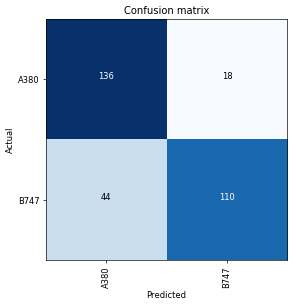

In [35]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

## Precision and Recall

It's good metrics to evaluate how the model perform : https://en.wikipedia.org/wiki/Precision_and_recall

We will compute them from the confusion matrix.

In [36]:
data.classes
cm = interp.confusion_matrix()
cm

['A380', 'B747']

array([[136,  18],
       [ 44, 110]])

In [37]:

# precission = VP / (VP + FP)
precision = cm[0][0]/(cm[0][1]+cm[0][0]);
print("Precision : ", precision)
# recall =  = VP / (VP + FN)
recall = cm[0][0]/(cm[1][0]+cm[0][0]);
print("recall : ", recall)
F1 = 2 * ((precision*recall)/(precision + recall))
print("F1 : ", F1)
F2 = 5 * ((precision*recall)/(4*precision + recall))
print("F2 : ", F2)

Precision :  0.8831168831168831
recall :  0.7555555555555555
F1 :  0.8143712574850299
F2 :  0.7780320366132721


Let's have a look at the 16 worst classified images.

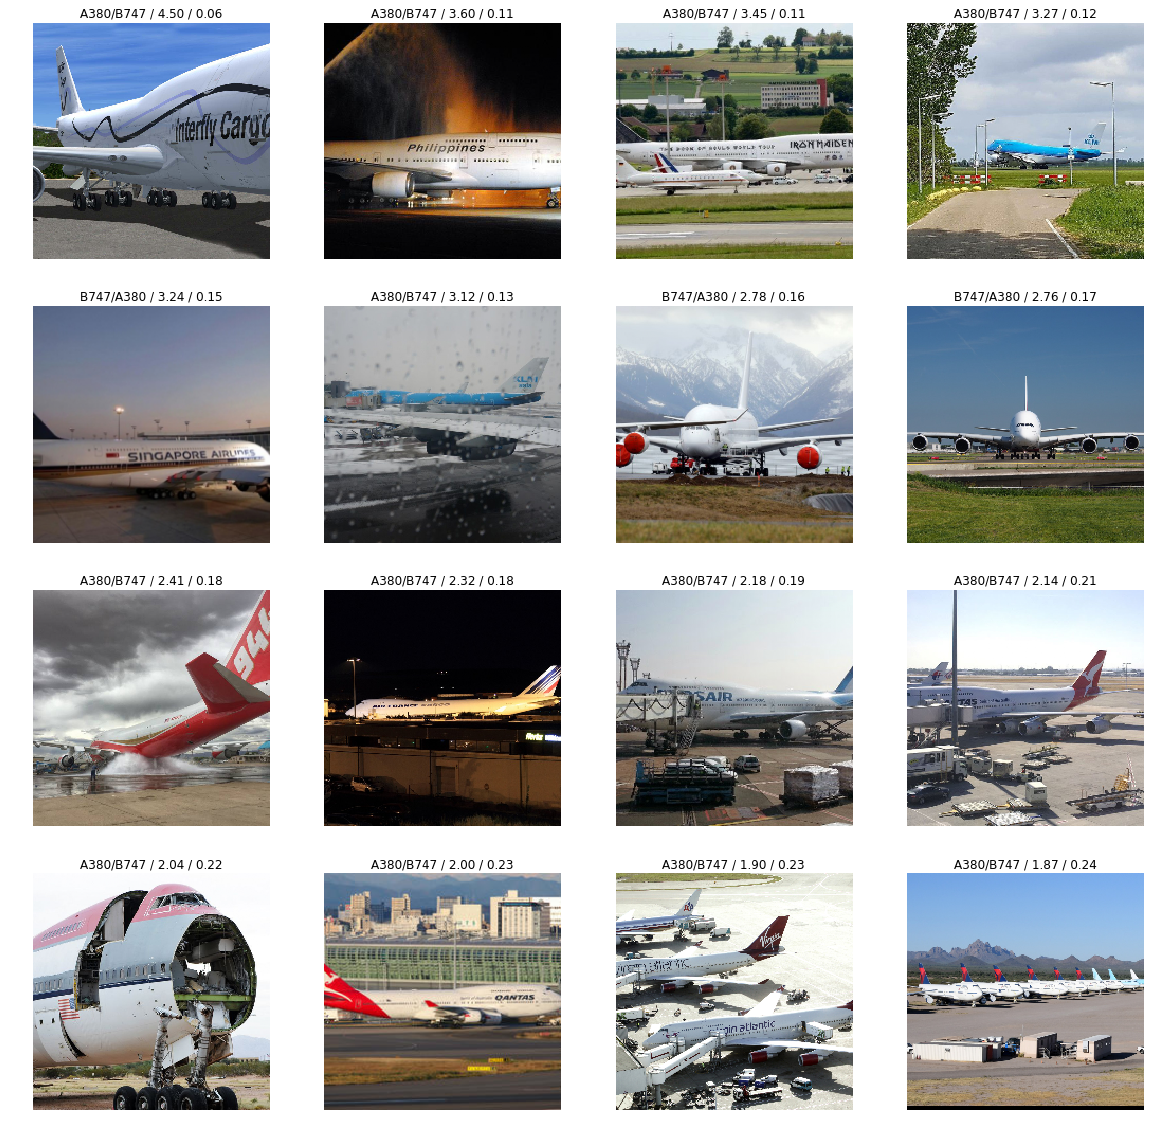

In [38]:
interp.plot_top_losses(16, figsize=(20,20))